In [34]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, box, LineString
from shapely import intersection
from tqdm.notebook import tqdm
import glob
from functools import reduce

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r

In [85]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'
fn_roads_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/roads.parquet'
dir_roads = '/Volumes/Extreme SSD/largest_plots/raw_data/roads'
fn_roads_to_type = '/Users/andrewbartnof/Documents/rmi/largest_plot/roads_to_types/roads_to_types.csv'

In [20]:
RoadsToTypeRaw = pd.read_csv(fn_roads_to_type, skiprows=1)
RoadsToTypeRaw['est_width_m'] = RoadsToTypeRaw['lanes'] * RoadsToTypeRaw['meters per lane']
RoadsToType = RoadsToTypeRaw[['mtfcc', 'est_width_m']]
RoadsToType.rename(columns={'mtfcc':'MTFCC'}, inplace=True)
RoadsToType

/var/folders/zh/p6wj0vfs3qq684w4b1m0_tvr0000gn/T/ipykernel_1794/3751472375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RoadsToType.rename(columns={'mtfcc':'MTFCC'}, inplace=True)


,MTFCC,est_width_m
0,S1400,6.60
1,S1740,3.15
2,S1750,6.30
3,S1500,3.15
4,S1200,10.35
5,S1630,9.60
6,S1640,10.35
7,S1730,3.15
8,S1780,3.15
9,S1100,18.00


In [60]:
Aoi = gpd.read_parquet(fn_aoi).set_geometry('aoi').set_crs(epsg=target_epsg)

In [14]:
pattern_roads = dir_roads + '/*.zip'
fn_list_roads = glob.glob(pattern_roads)

Iterate through each AOI x each roads file.
- Keep any rows that overlap at all with the AOI
- Each AOI's results will be stored as a list of geopandas tables.

In [65]:
intersection_dict = {}
for i in Aoi.index:
    intersection_dict[i] = list()
bad_fn_list = []

for fn_roads in tqdm(fn_list_roads):
    # read Roads shape file, make sure the joins worked
    Roads = gpd.read_file(fn_roads).to_crs(epsg=target_epsg).set_geometry('geometry')
    Roads = Roads.merge(right=RoadsToType, how='left', on='MTFCC')
    
    if sum(Roads['est_width_m'].isna()) > 0:
        bad_fn_list.append(fn_roads)
        pass
    else:    
        
        # create polygons shape
        RoadPolygons = Roads['geometry'].buffer(distance=Roads['est_width_m'], cap_style='round')
        RoadPolygons = RoadPolygons.to_frame().rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(epsg=target_epsg)
        
        # iterate through AOIs
        for i in Aoi.index:
                single_aoi = Aoi.loc[[i]]
                Intersection = gpd.sjoin(RoadPolygons, single_aoi, how='inner', predicate='intersects')
                if Intersection.shape[0] > 0:
                    intersection_dict[i].append(Intersection)
                else:
                    pass

  0%|          | 0/3233 [00:00<?, ?it/s]

For each entry in the previous dictionary:
- flatten the list of tables into one table
- flatten the geometries in this new table into one geometry file
- trim the flat geometry to the dimensions of the AOI box

In [69]:
overlay_dict = {}

for i in tqdm(intersection_dict.keys()):  # iterate through these indices, because in theory, an index from the AOI might not have intersected at all with the water files
    intersections_in_list = intersection_dict[i]
    roads_flat = pd.concat(intersections_in_list).reset_index(drop=True).unary_union

    single_aoi = Aoi.loc[[i]]
    overlay = single_aoi.intersection(roads_flat).to_frame().reset_index(drop=True).loc[0,0]
    overlay_dict[i] = overlay

  0%|          | 0/56 [00:00<?, ?it/s]

In [82]:
list(overlay_dict.keys()) == Aoi.index.tolist()

True

In [71]:
intersection_dict.keys() == overlay_dict.keys()

True

In [83]:
RoadsOverlay = gpd.GeoDataFrame({'index':overlay_dict.keys(), 'geometry':overlay_dict.values()}, crs='epsg:'+str(target_epsg))
RoadsOverlay.set_geometry('geometry', inplace=True)
RoadsOverlay.set_index('index', drop=True, inplace=True, verify_integrity=True)
RoadsOverlay.head()

,geometry
index,
0,"MULTIPOLYGON (((1064783.733 1251283.248, 10647..."
1,"MULTIPOLYGON (((1253970.757 1244022.868, 12539..."
2,"MULTIPOLYGON (((1280030.297 1420204.947, 12800..."
3,"MULTIPOLYGON (((1652992.164 1568650.524, 16529..."
4,"MULTIPOLYGON (((1517647.954 1484105.275, 15176..."


In [86]:
RoadsOverlay.to_parquet(fn_roads_overlay)

# Manual QC

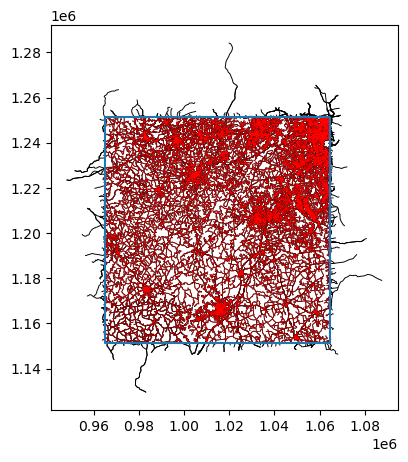

In [89]:
# Note that these are 'buffered', ie expanded, so we can see them easily here.
i = 0
fig, ax = plt.subplots(figsize=(5, 5))
Aoi.loc[[i]].boundary.plot(ax=ax)
gpd.GeoDataFrame(pd.concat(intersection_dict[i])).buffer(distance=200).plot(ax=ax, color='black')
RoadsOverlay.loc[[i]].buffer(distance=100).plot(ax=ax, color='red')
plt.show()

# Appendix

In [44]:
# appendix: test: can we use a series as the width for the buffer? answer is yes!
a = LineString([[0, 0], [1, 0]])
ww = [1, 2, 3, 4, 5]

Test = gpd.GeoDataFrame({'line':a, 'width':ww}).set_geometry('line')
test_buffer = Test['line'].buffer(distance=Test['width'], cap_style='square')
test_buffer.area

0      6.0
1     20.0
2     42.0
3     72.0
4    110.0
dtype: float64